In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import squeezenet1_0, resnet18
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
from PIL import Image
import re

drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
!pip install torchattack

In [57]:
from torchattack import PGD

In [58]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5); self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120); self.fc2 = nn.Linear(120, 84); self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1); x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x)); return self.fc3(x)

class SqueezeNetMNIST(nn.Module):
    def __init__(self):
        super(SqueezeNetMNIST, self).__init__()
        self.model = squeezenet1_0(num_classes=10)
        self.model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
    def forward(self, x):
        if x.shape[1] == 1: x = x.repeat(1, 3, 1, 1)
        return self.model(x)

class ResNet18MNIST(nn.Module):
    def __init__(self):
        super(ResNet18MNIST, self).__init__()
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    def forward(self, x):
        return self.model(x)

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ConvNetTiny(nn.Module):
    def __init__(self):
        super(ConvNetTiny, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.fc1 = nn.Linear(8 * 13 * 13, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetWide(nn.Module):
    def __init__(self):
        super(ConvNetWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetDeep(nn.Module):
    def __init__(self):
        super(ConvNetDeep, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 3 * 3, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super(MiniGoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.inception = InceptionModule(64, 16, 32, 24, 8, 8, 16)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class MiniDenseNet(nn.Module):
    def __init__(self):
        super(MiniDenseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(16 * 14 * 14, 10)
    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(out1))
        c2 = torch.cat([out1, out2], 1)
        out3 = F.relu(self.conv3(c2))
        x = self.pool(out3)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [59]:
model_configs = []

model_configs.append(('LeNet_Standard', 'lenet.pth', LeNet5))
model_configs.append(('LeNet_Robust', 'lenet_robust.pth', LeNet5))
model_configs.append(('Squeeze_Standard', 'squeezenet.pth', SqueezeNetMNIST))
model_configs.append(('Squeeze_Robust', 'squeezenet_robust.pth', SqueezeNetMNIST))

zoo_architectures = [
    ('Linear', LinearModel), ('MLP', MLP), ('ConvTiny', ConvNetTiny),
    ('Simple', SimpleCNN), ('ConvWide', ConvNetWide), ('ConvDeep', ConvNetDeep),
    ('LeNet', LeNet5), ('MiniVGG', MiniVGG), ('Squeeze', SqueezeNetMNIST),
    ('MiniInception', MiniGoogLeNet), ('MiniDense', MiniDenseNet), ('ResNet', ResNet18MNIST)
]

for seed in range(2):
    for name, arch_cls in zoo_architectures:
        model_configs.append((f"{name}_s{seed}", f"{name.lower()}_s{seed}.pth", arch_cls))

focus_models_names = ['LeNet_Standard', 'LeNet_Robust', 'Squeeze_Standard', 'Squeeze_Robust']

In [60]:
base_path = '/content/drive/My Drive/adversarial_mnist'
weights_dir = f'{base_path}/model_weights'
adv_dir = f'{base_path}/large_adversarial_examples'
external_data_path = f'{base_path}/external_dataset/test/pgd'

zoo_models = {}
for name, fname, arch_cls in model_configs:
    path = f"{weights_dir}/{fname}"
    m = arch_cls()
    m.load_state_dict(torch.load(path, map_location=device))
    m.to(device).eval()
    zoo_models[name] = m

In [61]:
def load_image_folder(path):
    if not os.path.exists(path): return None, None
    files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    if not files: return None, None

    transform = transforms.Compose([transforms.ToTensor()])
    ref_specific_data = datasets.MNIST(root='./data', train=False, download=True)

    images, labels = [], []
    pattern = re.compile(r'(\d+)')

    for fname in files:
        match = pattern.search(fname)
        if match:
            idx = int(match.group(1))
            if 0 <= idx < len(ref_specific_data.targets):
                try:
                    img = Image.open(os.path.join(path, fname)).convert('L')
                    images.append(transform(img))
                    labels.append(ref_specific_data.targets[idx])
                except: pass

    if not images: return None, None
    return torch.stack(images), torch.tensor(labels)

survey_path = f'{base_path}/external_dataset/test'
external_datasets = {}

if os.path.exists(survey_path):
    print(f"Scanning {survey_path}...")
    for attack_name in sorted(os.listdir(survey_path)):
        full_path = os.path.join(survey_path, attack_name)
        if os.path.isdir(full_path):
            imgs, lbls = load_image_folder(full_path)
            if imgs is not None:
                external_datasets[attack_name] = (imgs, lbls)
                print(f"Loaded {len(imgs)} images for {attack_name}")

Scanning /content/drive/My Drive/adversarial_mnist/external_dataset/test...
Loaded 1000 images for backdoor
Loaded 1000 images for bim
Loaded 1000 images for clean
Loaded 1000 images for cw
Loaded 1000 images for deepfool
Loaded 1000 images for fgsm
Loaded 1000 images for pgd


In [62]:
all_names = [c[0] for c in model_configs]
n_models = len(all_names)
matrix_acc = np.zeros((n_models, n_models))
matrix_pert = np.zeros((n_models, n_models))

adv_datasets = {}

for name, fname, _ in model_configs:
    path = f"{adv_dir}/500_adv_{fname}"
    adv_datasets[name] = torch.load(path)

for i, src_name in enumerate(all_names):
    src_data = adv_datasets[src_name]
    adv_imgs = src_data['adv'].to(device)
    lbls = src_data['lbl'].to(device)

    clean_imgs = None
    if 'clean' in src_data:
        clean_imgs = src_data['clean'].to(device)

    for j, tgt_name in enumerate(all_names):
        model = zoo_models[tgt_name]
        with torch.no_grad():
            preds = model(adv_imgs).argmax(1)

            acc = (preds == lbls).float().mean().item() * 100
            matrix_acc[i, j] = acc

            if clean_imgs is not None:
                success_indices = (preds != lbls)
                if success_indices.sum() > 0:
                    diff = adv_imgs[success_indices] - clean_imgs[success_indices]
                    norms = diff.view(diff.size(0), -1).norm(p=2, dim=1)
                    avg_pert = norms.mean().item()
                    matrix_pert[i, j] = avg_pert

In [63]:
focus_models_names = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust', 'Squeeze_Robust']
focus_indices = [all_names.index(n) for n in focus_models_names]

clean_accs = []
whitebox_accs = []
zoo_defense_scores = []
zoo_offense_scores = []
avg_pert_scores = []
blackbox_results = {k: [] for k in external_datasets.keys()}

for idx in focus_indices:
    name = all_names[idx]
    data = adv_datasets[name]

    clean_accs.append(data['score_clean'])
    whitebox_accs.append(data['score_robust'])

    incoming_attacks = [matrix_acc[i, idx] for i in range(n_models) if i != idx]
    zoo_defense_scores.append(np.mean(incoming_attacks))

    outgoing_attacks = [100 - matrix_acc[idx, j] for j in range(n_models) if j != idx]
    zoo_offense_scores.append(np.mean(outgoing_attacks))

    incoming_perts = [matrix_pert[i, idx] for i in range(n_models) if matrix_pert[i, idx] > 0]
    avg_pert_scores.append(np.mean(incoming_perts) if incoming_perts else 0)

    for atk_name, (imgs, lbls) in external_datasets.items():
        with torch.no_grad():
            preds = zoo_models[name](imgs.to(device)).argmax(1)
            acc = (preds == lbls.to(device)).float().mean().item() * 100
            blackbox_results[atk_name].append(acc)

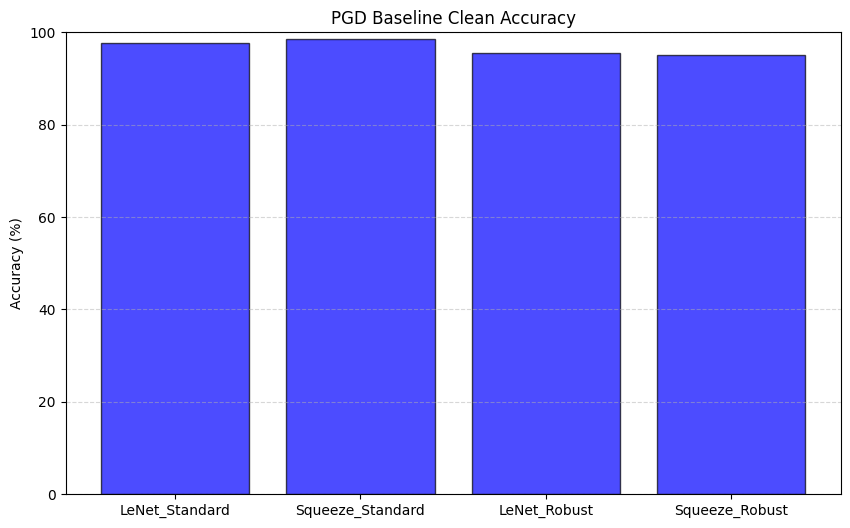

PGD Baseline Clean Accuracy:
LeNet_Standard: 97.65%
Squeeze_Standard: 98.44%
LeNet_Robust: 95.40%
Squeeze_Robust: 95.04%


In [64]:
x = np.arange(len(focus_models_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, clean_accs, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("PGD Baseline Clean Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("PGD Baseline Clean Accuracy:")
for n, c in zip(focus_models_names, clean_accs):
    print(f"{n}: {c:.2f}%")

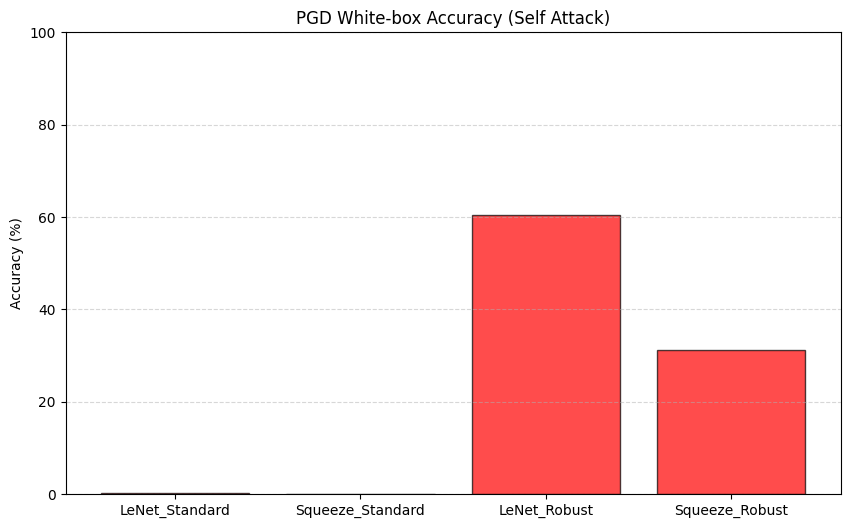

PGD White-box Accuracy:
LeNet_Standard: 0.18%
Squeeze_Standard: 0.01%
LeNet_Robust: 60.46%
Squeeze_Robust: 31.23%


In [65]:
plt.figure(figsize=(10, 6))
plt.bar(x, whitebox_accs, color='red', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("PGD White-box Accuracy (Self Attack)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("PGD White-box Accuracy:")
for n, w in zip(focus_models_names, whitebox_accs):
    print(f"{n}: {w:.2f}%")

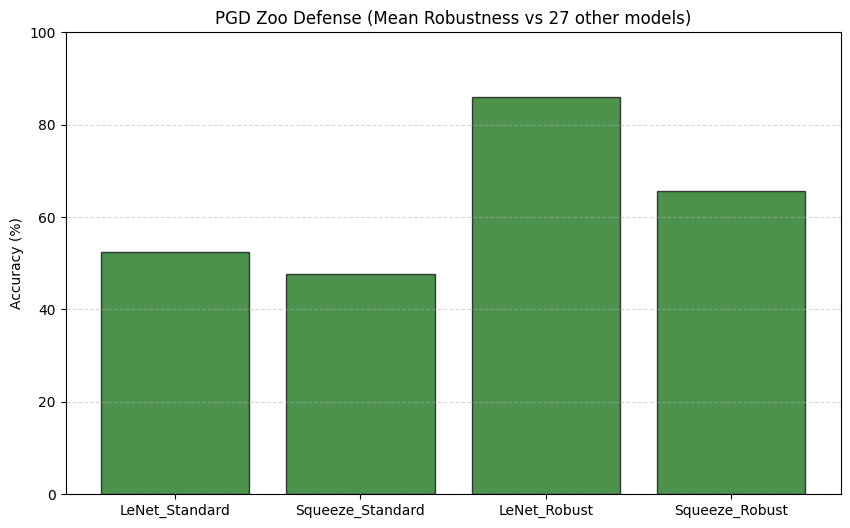

PGD Zoo Defense Score:
LeNet_Standard: 52.49%
Squeeze_Standard: 47.70%
LeNet_Robust: 85.99%
Squeeze_Robust: 65.58%


In [66]:
plt.figure(figsize=(10, 6))
plt.bar(x, zoo_defense_scores, color='darkgreen', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title(f"PGD Zoo Defense (Mean Robustness vs {n_models-1} other models)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("PGD Zoo Defense Score:")
for n, d in zip(focus_models_names, zoo_defense_scores):
    print(f"{n}: {d:.2f}%")

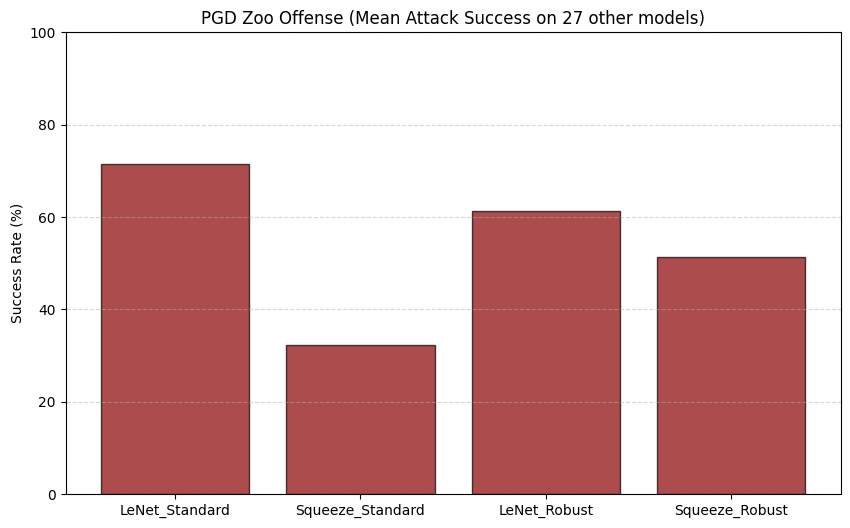

PGD Zoo Offense Score:
LeNet_Standard: 71.53%
Squeeze_Standard: 32.26%
LeNet_Robust: 61.39%
Squeeze_Robust: 51.41%


In [67]:
plt.figure(figsize=(10, 6))
plt.bar(x, zoo_offense_scores, color='darkred', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Success Rate (%)")
plt.title(f"PGD Zoo Offense (Mean Attack Success on {n_models-1} other models)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("PGD Zoo Offense Score:")
for n, o in zip(focus_models_names, zoo_offense_scores):
    print(f"{n}: {o:.2f}%")

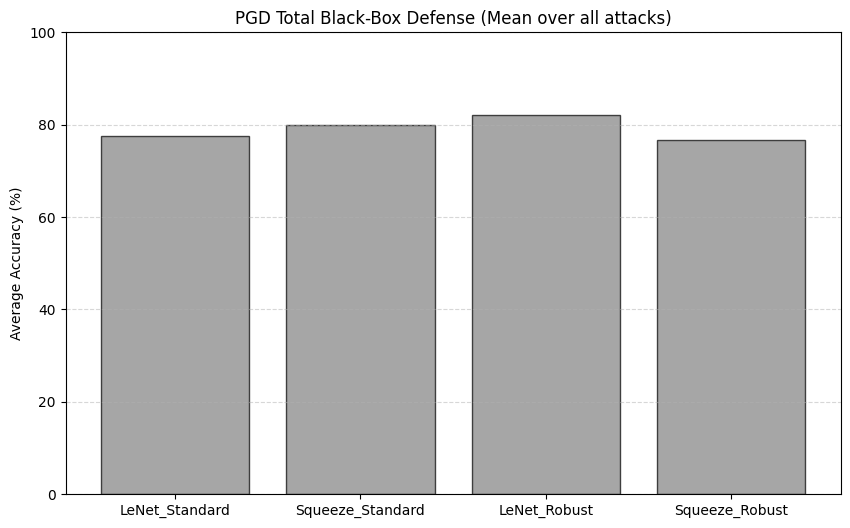

PGD Total Black-Box Results:
LeNet_Standard: 77.54%
Squeeze_Standard: 79.97%
LeNet_Robust: 82.03%
Squeeze_Robust: 76.70%


In [68]:
x = np.arange(len(focus_models_names))

# Calculate mean accuracy across all external datasets for each model
all_bb_scores = np.array(list(blackbox_results.values()))
avg_bb_scores = np.mean(all_bb_scores, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(x, avg_bb_scores, color='gray', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Average Accuracy (%)")
plt.title("PGD Total Black-Box Defense (Mean over all attacks)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("PGD Total Black-Box Results:")
for n, s in zip(focus_models_names, avg_bb_scores):
    print(f"{n}: {s:.2f}%")

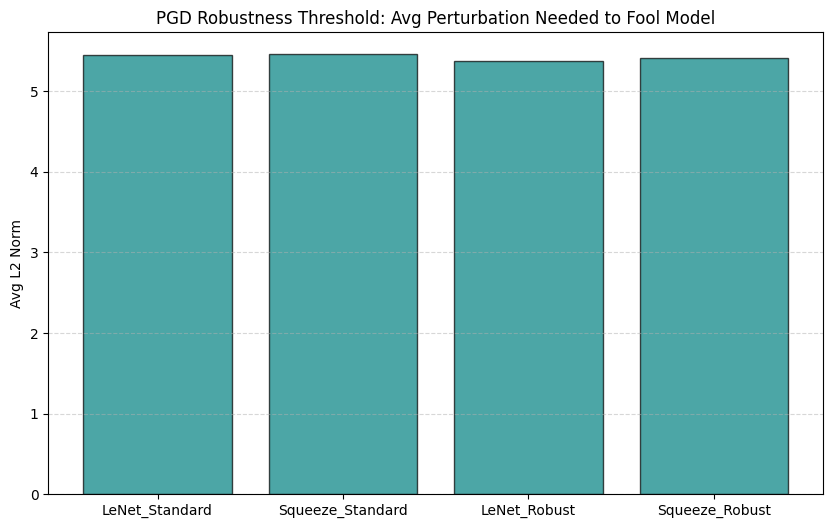

PGD Avg Perturbation Data:
LeNet_Standard: 5.4531
Squeeze_Standard: 5.4576
LeNet_Robust: 5.3690
Squeeze_Robust: 5.4101


In [69]:
plt.figure(figsize=(10, 6))
plt.bar(x, avg_pert_scores, color='teal', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Avg L2 Norm")
plt.title("PGD Robustness Threshold: Avg Perturbation Needed to Fool Model")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("PGD Avg Perturbation Data:")
for n, p in zip(focus_models_names, avg_pert_scores):
    print(f"{n}: {p:.4f}")

In [70]:
!pip install torchattacks

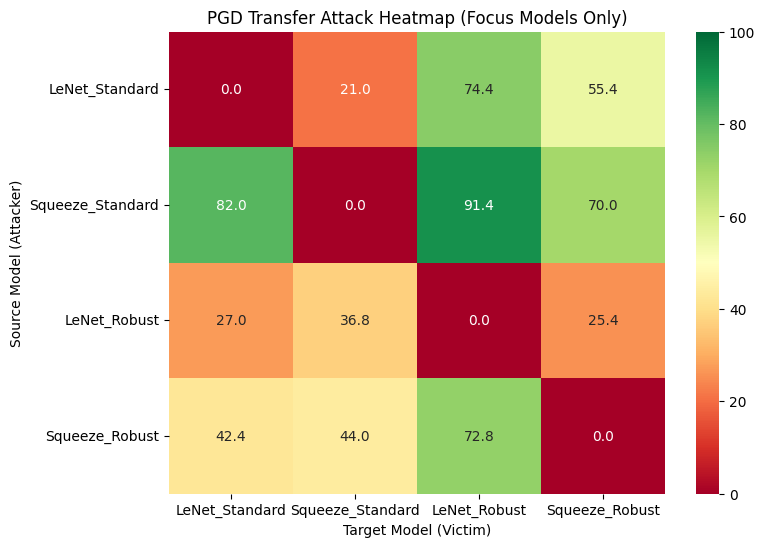

PGD Standard Transfer Attack Heatmap Data (Victim Accuracy):
Attacker: LeNet_Standard -> Victim: LeNet_Standard : 0.00%
Attacker: LeNet_Standard -> Victim: Squeeze_Standard : 21.00%
Attacker: LeNet_Standard -> Victim: LeNet_Robust : 74.40%
Attacker: LeNet_Standard -> Victim: Squeeze_Robust : 55.40%
Attacker: Squeeze_Standard -> Victim: LeNet_Standard : 82.00%
Attacker: Squeeze_Standard -> Victim: Squeeze_Standard : 0.00%
Attacker: Squeeze_Standard -> Victim: LeNet_Robust : 91.40%
Attacker: Squeeze_Standard -> Victim: Squeeze_Robust : 70.00%
Attacker: LeNet_Robust -> Victim: LeNet_Standard : 27.00%
Attacker: LeNet_Robust -> Victim: Squeeze_Standard : 36.80%
Attacker: LeNet_Robust -> Victim: LeNet_Robust : 0.00%
Attacker: LeNet_Robust -> Victim: Squeeze_Robust : 25.40%
Attacker: Squeeze_Robust -> Victim: LeNet_Standard : 42.40%
Attacker: Squeeze_Robust -> Victim: Squeeze_Standard : 44.00%
Attacker: Squeeze_Robust -> Victim: LeNet_Robust : 72.80%
Attacker: Squeeze_Robust -> Victim: Squeez

In [71]:
focus_matrix = matrix_acc[np.ix_(focus_indices, focus_indices)]

plt.figure(figsize=(8, 6))
sns.heatmap(focus_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=focus_models_names, yticklabels=focus_models_names)
plt.title("PGD Transfer Attack Heatmap (Focus Models Only)")
plt.ylabel("Source Model (Attacker)")
plt.xlabel("Target Model (Victim)")
plt.show()

print("PGD Standard Transfer Attack Heatmap Data (Victim Accuracy):")
for i, src in enumerate(focus_models_names):
    for j, tgt in enumerate(focus_models_names):
        print(f"Attacker: {src} -> Victim: {tgt} : {focus_matrix[i, j]:.2f}%")

In [72]:
from torchattacks import CW, Pixle

transform = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [73]:
from tqdm import tqdm

attack_configs = [
    ('CW', CW, {'c': 1, 'kappa': 0, 'steps': 50, 'lr': 0.01}),
    ('Pixle', Pixle, {'restarts': 10})
]

for atk_name, atk_class, atk_params in attack_configs:
    for name in tqdm(all_names, desc=f"Models ({atk_name})"):
        fname = [x[1] for x in model_configs if x[0] == name][0]
        save_path = f"{adv_dir}/500_adv_{atk_name}_{fname}"

        if os.path.exists(save_path):
            continue

        model = zoo_models[name]
        try:
            adversary = atk_class(model, **atk_params)
        except:
            adversary = atk_class(model)

        adv_list, clean_list, lbl_list = [], [], []

        for data, target in tqdm(test_loader, desc="Generating", leave=False):
            if len(adv_list) * 64 >= 500: break
            data, target = data.to(device), target.to(device)
            adv = adversary(data, target)
            adv_list.append(adv.cpu())
            clean_list.append(data.cpu())
            lbl_list.append(target.cpu())

        adv_imgs = torch.cat(adv_list)[:500]
        clean_imgs = torch.cat(clean_list)[:500]
        labels = torch.cat(lbl_list)[:500]

        with torch.no_grad():
            preds = model(adv_imgs.to(device)).argmax(1)
            rob_acc = (preds == labels.to(device)).float().mean().item() * 100

            clean_preds = model(clean_imgs.to(device)).argmax(1)
            clean_acc = (clean_preds == labels.to(device)).float().mean().item() * 100

        torch.save({
            'clean': clean_imgs,
            'adv': adv_imgs,
            'lbl': labels,
            'score_clean': clean_acc,
            'score_robust': rob_acc
        }, save_path)

Models (Pixle): 100%|██████████| 28/28 [00:00<00:00, 4925.58it/s]


In [74]:
def calculate_metrics(attack_name):
    matrix_acc = np.zeros((n_models, n_models))
    matrix_pert = np.zeros((n_models, n_models))

    zoo_data = {}
    for name in all_names:
        fname = [x[1] for x in model_configs if x[0] == name][0]
        zoo_data[name] = torch.load(f"{adv_dir}/500_adv_{attack_name}_{fname}")

    for i, src_name in enumerate(all_names):
        data = zoo_data[src_name]
        adv = data['adv'].to(device)
        lbl = data['lbl'].to(device)
        clean = data['clean'].to(device)

        for j, tgt_name in enumerate(all_names):
            tgt_model = zoo_models[tgt_name]
            with torch.no_grad():
                preds = tgt_model(adv).argmax(1)
                acc = (preds == lbl).float().mean().item() * 100
                matrix_acc[i, j] = acc

                succ = (preds != lbl)
                if succ.sum() > 0:
                    diff = adv[succ] - clean[succ]
                    norms = diff.view(diff.size(0), -1).norm(p=2, dim=1)
                    matrix_pert[i, j] = norms.mean().item()

    results = {
        'clean': [], 'white': [], 'zoo_def': [], 'zoo_off': [],
        'bbox': {k: [] for k in external_datasets.keys()},
        'pert': [], 'matrix': matrix_acc
    }

    focus_indices = [all_names.index(n) for n in focus_models_names]

    for idx in focus_indices:
        name = all_names[idx]

        results['clean'].append(zoo_data[name]['score_clean'])
        results['white'].append(matrix_acc[idx, idx])

        incoming = [matrix_acc[i, idx] for i in range(n_models) if i != idx]
        results['zoo_def'].append(np.mean(incoming))

        outgoing = [100 - matrix_acc[idx, j] for j in range(n_models) if j != idx]
        results['zoo_off'].append(np.mean(outgoing))

        incoming_pert = [matrix_pert[i, idx] for i in range(n_models) if matrix_pert[i, idx] > 0]
        results['pert'].append(np.mean(incoming_pert) if incoming_pert else 0)

        for atk_k, (imgs, lbls) in external_datasets.items():
            with torch.no_grad():
                bb_preds = zoo_models[name](imgs.to(device)).argmax(1)
                acc = (bb_preds == lbls.to(device)).float().mean().item() * 100
                results['bbox'][atk_k].append(acc)

    return results

In [75]:
cw_metrics = calculate_metrics('CW')

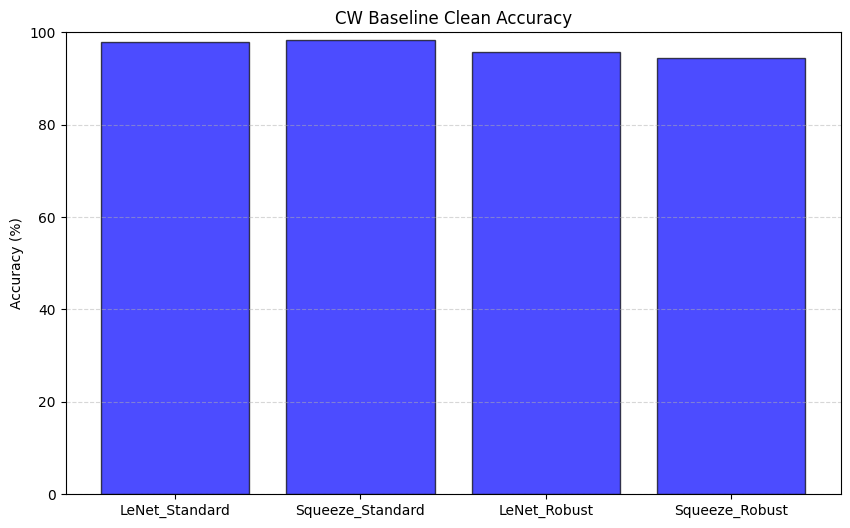

CW Baseline Clean Accuracy:
LeNet_Standard: 97.80%
Squeeze_Standard: 98.20%
LeNet_Robust: 95.80%
Squeeze_Robust: 94.40%


In [76]:
x = np.arange(len(focus_models_names))
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['clean'], color='blue', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("CW Baseline Clean Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("CW Baseline Clean Accuracy:")
for n, c in zip(focus_models_names, cw_metrics['clean']):
    print(f"{n}: {c:.2f}%")

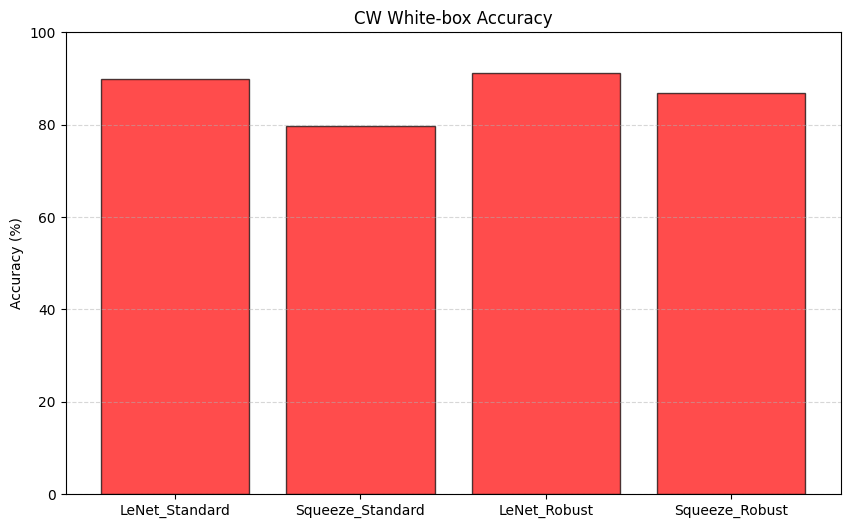

CW White-box Accuracy:
LeNet_Standard: 89.80%
Squeeze_Standard: 79.60%
LeNet_Robust: 91.20%
Squeeze_Robust: 86.80%


In [77]:
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['white'], color='red', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("CW White-box Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("CW White-box Accuracy:")
for n, o in zip(focus_models_names, cw_metrics['white']):
    print(f"{n}: {o:.2f}%")

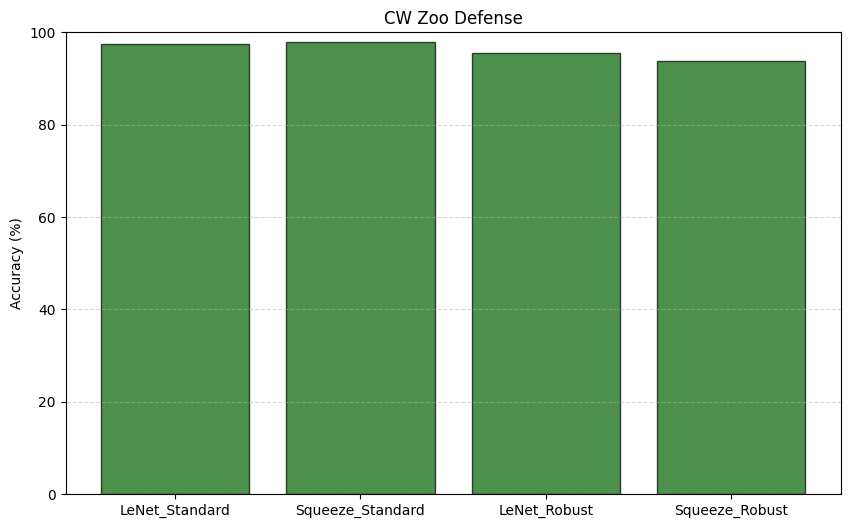

CW Zoo Defense Score:
LeNet_Standard: 97.33%
Squeeze_Standard: 97.87%
LeNet_Robust: 95.50%
Squeeze_Robust: 93.73%


In [78]:
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['zoo_def'], color='darkgreen', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("CW Zoo Defense")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("CW Zoo Defense Score:")
for n, d in zip(focus_models_names, cw_metrics['zoo_def']):
    print(f"{n}: {d:.2f}%")

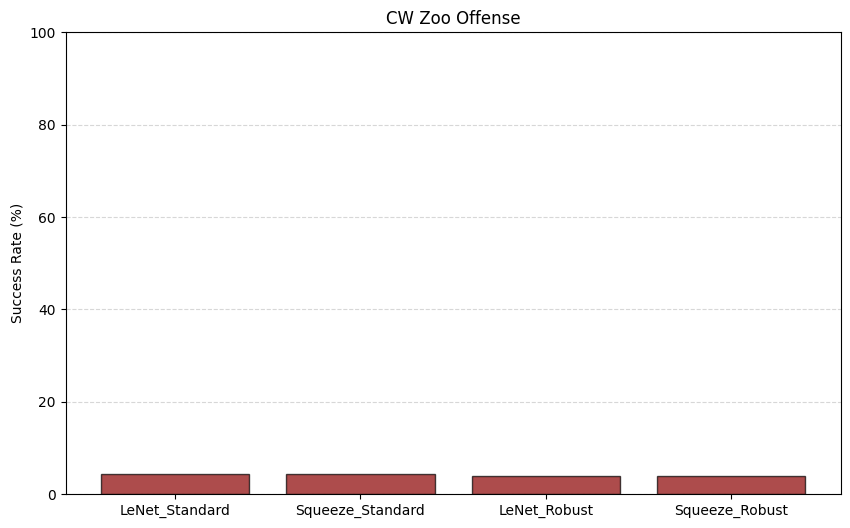

CW Zoo Offense Score:
LeNet_Standard: 4.33%
Squeeze_Standard: 4.27%
LeNet_Robust: 3.98%
Squeeze_Robust: 3.99%


In [79]:
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['zoo_off'], color='darkred', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Success Rate (%)")
plt.title("CW Zoo Offense")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("CW Zoo Offense Score:")
for n, o in zip(focus_models_names, cw_metrics['zoo_off']):
    print(f"{n}: {o:.2f}%")

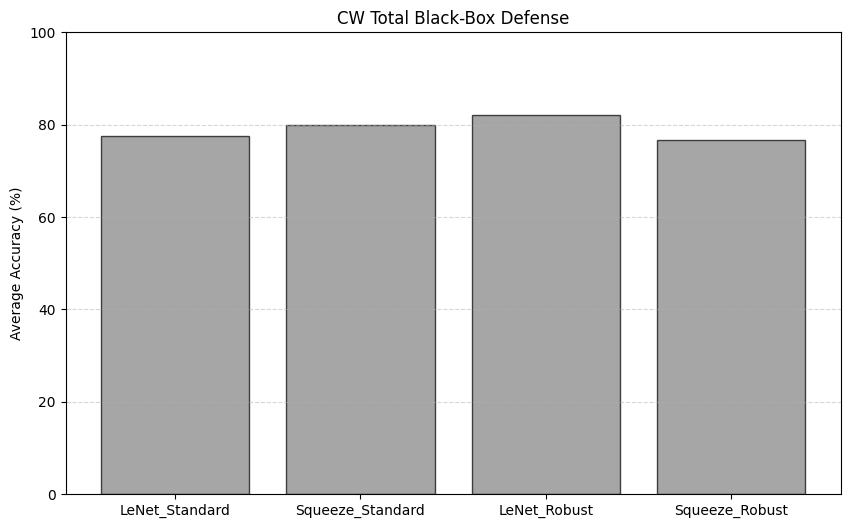

CW Total Black-Box Results:
LeNet_Standard: 77.54%
Squeeze_Standard: 79.97%
LeNet_Robust: 82.03%
Squeeze_Robust: 76.70%


In [80]:
x = np.arange(len(focus_models_names))

all_cw_bb_scores = np.array(list(cw_metrics['bbox'].values()))
avg_cw_bb_scores = np.mean(all_cw_bb_scores, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(x, avg_cw_bb_scores, color='gray', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Average Accuracy (%)")
plt.title("CW Total Black-Box Defense")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("CW Total Black-Box Results:")
for n, s in zip(focus_models_names, avg_cw_bb_scores):
    print(f"{n}: {s:.2f}%")

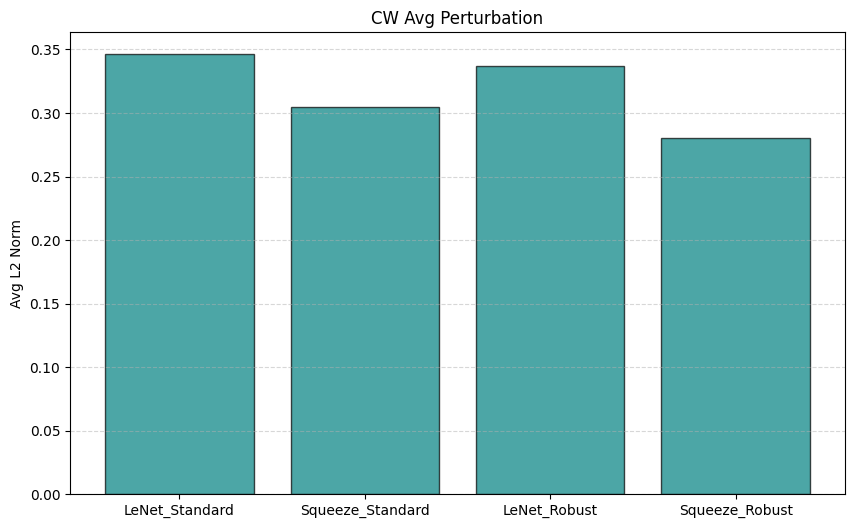

CW Avg Perturbation Data:
LeNet_Standard: 0.3463
Squeeze_Standard: 0.3049
LeNet_Robust: 0.3373
Squeeze_Robust: 0.2806


In [81]:
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['pert'], color='teal', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Avg L2 Norm")
plt.title("CW Avg Perturbation")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("CW Avg Perturbation Data:")
for n, p in zip(focus_models_names, cw_metrics['pert']):
    print(f"{n}: {p:.4f}")

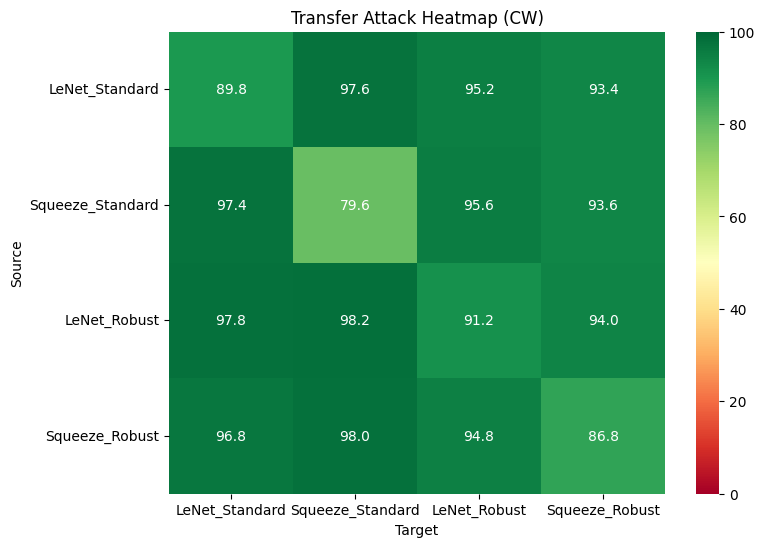

Transfer Attack Heatmap (CW) Data (Victim Accuracy):
Attacker: LeNet_Standard -> Victim: LeNet_Standard : 89.80%
Attacker: LeNet_Standard -> Victim: Squeeze_Standard : 97.60%
Attacker: LeNet_Standard -> Victim: LeNet_Robust : 95.20%
Attacker: LeNet_Standard -> Victim: Squeeze_Robust : 93.40%
Attacker: Squeeze_Standard -> Victim: LeNet_Standard : 97.40%
Attacker: Squeeze_Standard -> Victim: Squeeze_Standard : 79.60%
Attacker: Squeeze_Standard -> Victim: LeNet_Robust : 95.60%
Attacker: Squeeze_Standard -> Victim: Squeeze_Robust : 93.60%
Attacker: LeNet_Robust -> Victim: LeNet_Standard : 97.80%
Attacker: LeNet_Robust -> Victim: Squeeze_Standard : 98.20%
Attacker: LeNet_Robust -> Victim: LeNet_Robust : 91.20%
Attacker: LeNet_Robust -> Victim: Squeeze_Robust : 94.00%
Attacker: Squeeze_Robust -> Victim: LeNet_Standard : 96.80%
Attacker: Squeeze_Robust -> Victim: Squeeze_Standard : 98.00%
Attacker: Squeeze_Robust -> Victim: LeNet_Robust : 94.80%
Attacker: Squeeze_Robust -> Victim: Squeeze_Rob

In [82]:
f_idx = [all_names.index(n) for n in focus_models_names]
sub_matrix = cw_metrics['matrix'][np.ix_(f_idx, f_idx)]
plt.figure(figsize=(8, 6))
sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=focus_models_names, yticklabels=focus_models_names)
plt.title("Transfer Attack Heatmap (CW)")
plt.ylabel("Source")
plt.xlabel("Target")
plt.show()

print("Transfer Attack Heatmap (CW) Data (Victim Accuracy):")
for i, src in enumerate(focus_models_names):
    for j, tgt in enumerate(focus_models_names):
        print(f"Attacker: {src} -> Victim: {tgt} : {sub_matrix[i, j]:.2f}%")

In [83]:
pixle_metrics = calculate_metrics('Pixle')

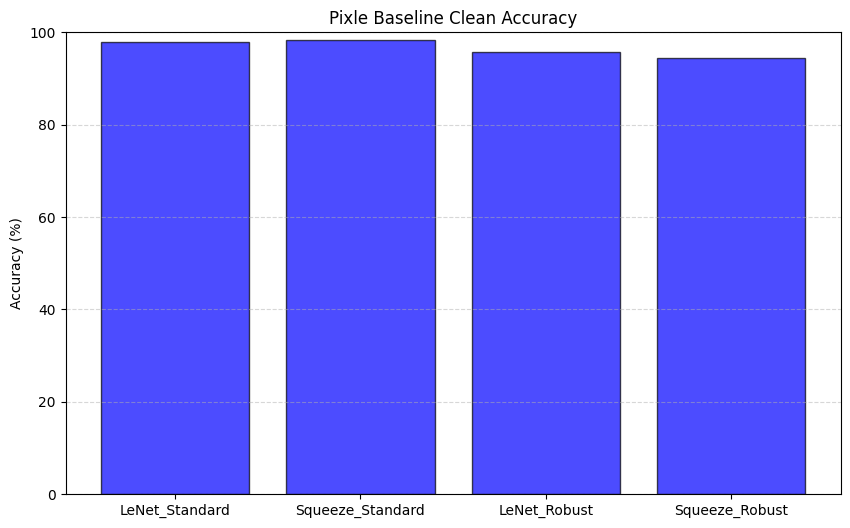

Pixle Baseline Clean Accuracy:
LeNet_Standard: 97.80%
Squeeze_Standard: 98.20%
LeNet_Robust: 95.80%
Squeeze_Robust: 94.40%


In [84]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['clean'], color='blue', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Pixle Baseline Clean Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Pixle Baseline Clean Accuracy:")
for n, c in zip(focus_models_names, pixle_metrics['clean']):
    print(f"{n}: {c:.2f}%")

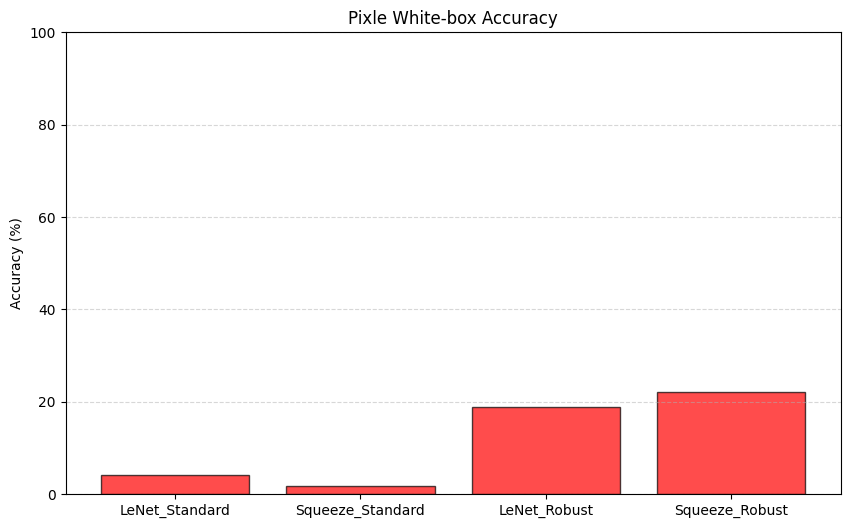

Pixle White-box Accuracy:
LeNet_Standard: 4.20%
Squeeze_Standard: 1.80%
LeNet_Robust: 18.80%
Squeeze_Robust: 22.20%


In [85]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['white'], color='red', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Pixle White-box Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Pixle White-box Accuracy:")
for n, o in zip(focus_models_names, pixle_metrics['white']):
    print(f"{n}: {o:.2f}%")

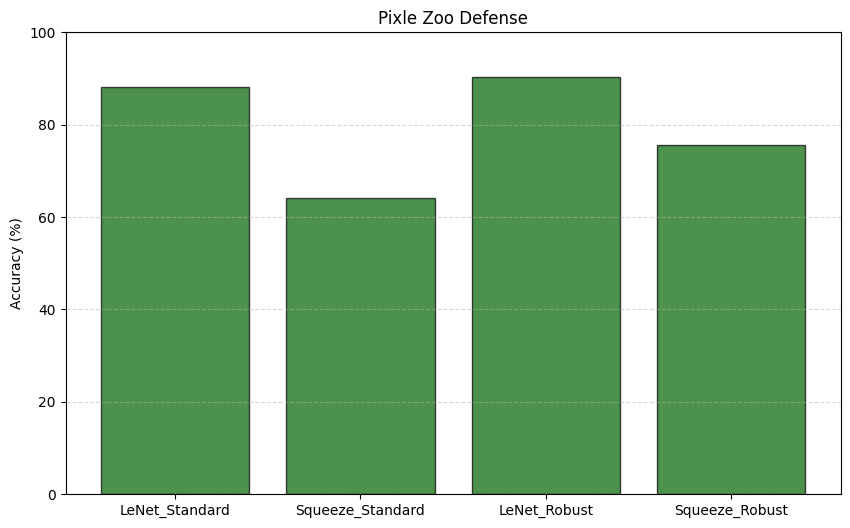

Pixle Zoo Defense Score:
LeNet_Standard: 97.33%
Squeeze_Standard: 97.87%
LeNet_Robust: 95.50%
Squeeze_Robust: 93.73%


In [86]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['zoo_def'], color='darkgreen', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Pixle Zoo Defense")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Pixle Zoo Defense Score:")
for n, d in zip(focus_models_names, cw_metrics['zoo_def']):
    print(f"{n}: {d:.2f}%")

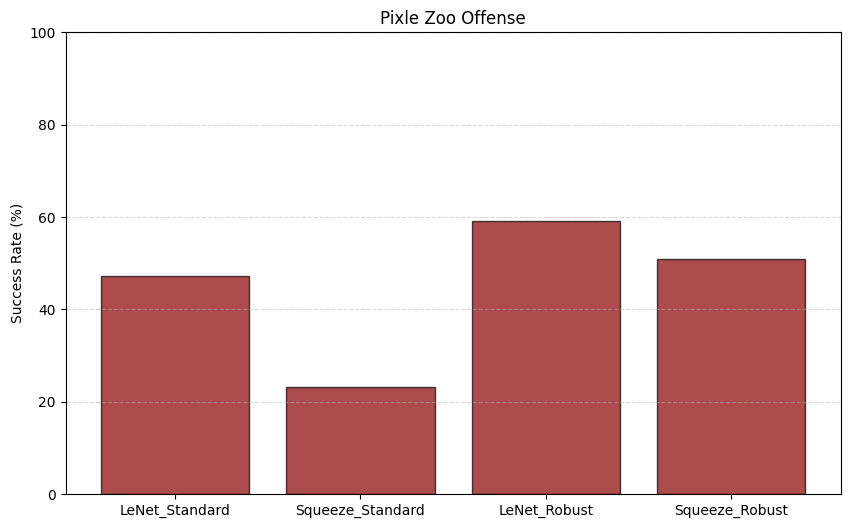

Pixle Zoo Offense Score:
LeNet_Standard: 47.17%
Squeeze_Standard: 23.30%
LeNet_Robust: 59.16%
Squeeze_Robust: 50.86%


In [87]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['zoo_off'], color='darkred', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Success Rate (%)")
plt.title("Pixle Zoo Offense")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Pixle Zoo Offense Score:")
for n, o in zip(focus_models_names, pixle_metrics['zoo_off']):
    print(f"{n}: {o:.2f}%")

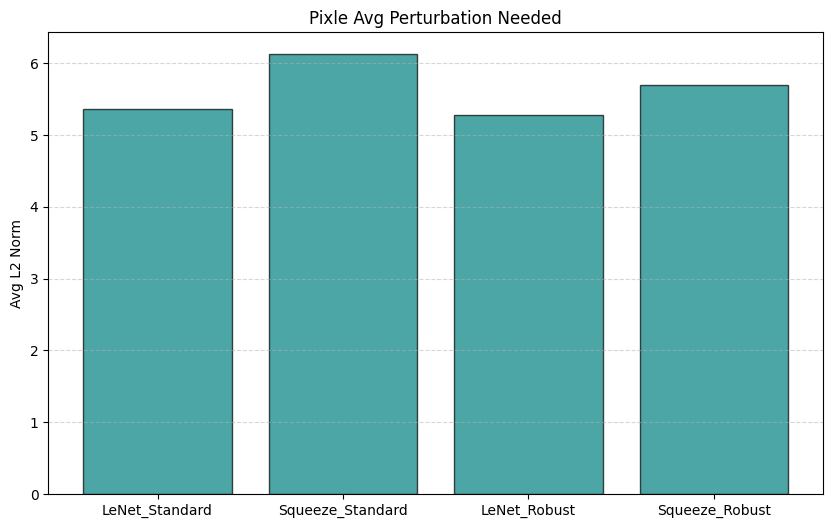

Pixle Avg Perturbation Data:
LeNet_Standard: 5.3606
Squeeze_Standard: 6.1245
LeNet_Robust: 5.2737
Squeeze_Robust: 5.7017


In [88]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['pert'], color='teal', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Avg L2 Norm")
plt.title("Pixle Avg Perturbation Needed")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Pixle Avg Perturbation Data:")
for n, v in zip(focus_models_names, pixle_metrics['pert']):
    print(f"{n}: {v:.4f}")

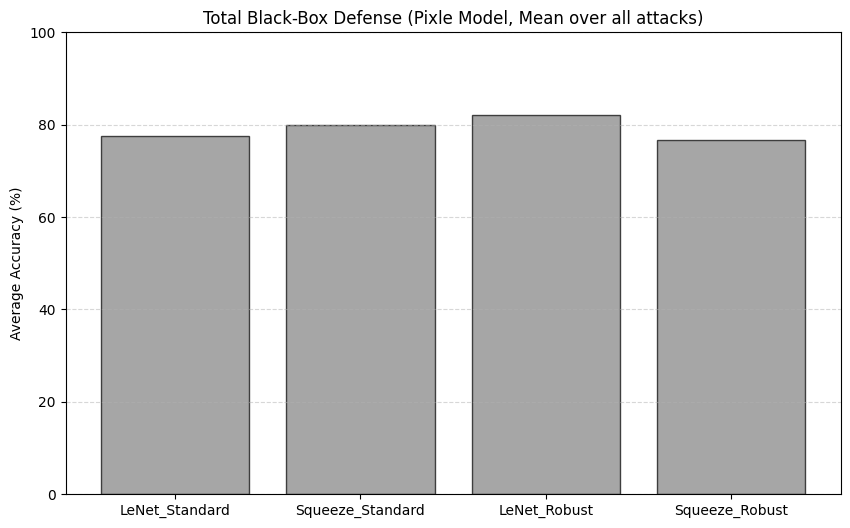

Pixle Total Black-Box Results:
LeNet_Standard: 77.54%
Squeeze_Standard: 79.97%
LeNet_Robust: 82.03%
Squeeze_Robust: 76.70%


In [89]:
x = np.arange(len(focus_models_names))

all_pixle_bb_scores = np.array(list(pixle_metrics['bbox'].values()))
avg_pixle_bb_scores = np.mean(all_pixle_bb_scores, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(x, avg_pixle_bb_scores, color='gray', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Average Accuracy (%)")
plt.title("Total Black-Box Defense (Pixle Model, Mean over all attacks)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Pixle Total Black-Box Results:")
for n, s in zip(focus_models_names, avg_pixle_bb_scores):
    print(f"{n}: {s:.2f}%")

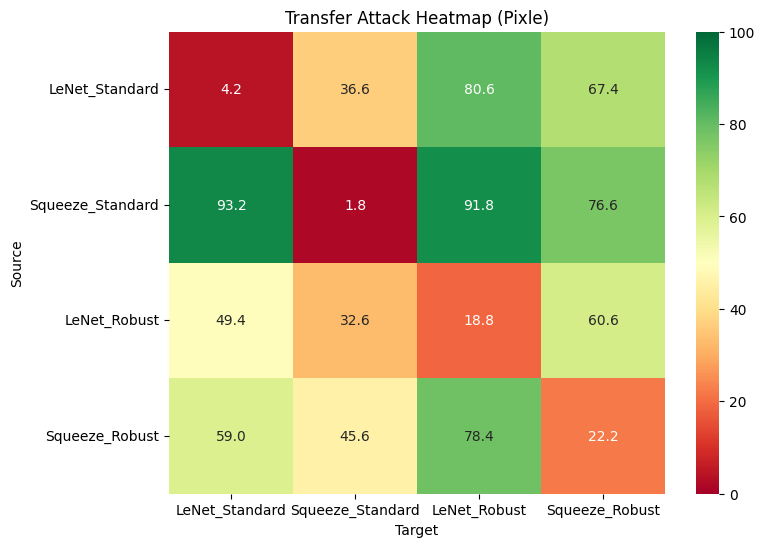

Transfer Attack Heatmap (Pixle) Data (Victim Accuracy):
Attacker: LeNet_Standard -> Victim: LeNet_Standard : 4.20%
Attacker: LeNet_Standard -> Victim: Squeeze_Standard : 36.60%
Attacker: LeNet_Standard -> Victim: LeNet_Robust : 80.60%
Attacker: LeNet_Standard -> Victim: Squeeze_Robust : 67.40%
Attacker: Squeeze_Standard -> Victim: LeNet_Standard : 93.20%
Attacker: Squeeze_Standard -> Victim: Squeeze_Standard : 1.80%
Attacker: Squeeze_Standard -> Victim: LeNet_Robust : 91.80%
Attacker: Squeeze_Standard -> Victim: Squeeze_Robust : 76.60%
Attacker: LeNet_Robust -> Victim: LeNet_Standard : 49.40%
Attacker: LeNet_Robust -> Victim: Squeeze_Standard : 32.60%
Attacker: LeNet_Robust -> Victim: LeNet_Robust : 18.80%
Attacker: LeNet_Robust -> Victim: Squeeze_Robust : 60.60%
Attacker: Squeeze_Robust -> Victim: LeNet_Standard : 59.00%
Attacker: Squeeze_Robust -> Victim: Squeeze_Standard : 45.60%
Attacker: Squeeze_Robust -> Victim: LeNet_Robust : 78.40%
Attacker: Squeeze_Robust -> Victim: Squeeze_Ro

In [90]:
sub_matrix = pixle_metrics['matrix'][np.ix_(f_idx, f_idx)]
plt.figure(figsize=(8, 6))
sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=focus_models_names, yticklabels=focus_models_names)
plt.title("Transfer Attack Heatmap (Pixle)")
plt.ylabel("Source")
plt.xlabel("Target")
plt.show()

print("Transfer Attack Heatmap (Pixle) Data (Victim Accuracy):")
for i, src in enumerate(focus_models_names):
    for j, tgt in enumerate(focus_models_names):
        print(f"Attacker: {src} -> Victim: {tgt} : {sub_matrix[i, j]:.2f}%")

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Re-define data to ensure this cell is self-contained
robust_indices = [2, 3]
attacks = ['Standard', 'CW', 'Pixle']

def get_robust_mean(metric_list):
    return np.mean([metric_list[i] for i in robust_indices])

metrics_data = {
    "Baseline Clean Accuracy (%)": [
        get_robust_mean(clean_accs), get_robust_mean(cw_metrics['clean']), get_robust_mean(pixle_metrics['clean'])
    ],
    "White-box Defense (Robustness) (%)": [
        get_robust_mean(whitebox_accs), get_robust_mean(cw_metrics['white']), get_robust_mean(pixle_metrics['white'])
    ],
    "Zoo Defense (Mean Robustness) (%)": [
        get_robust_mean(zoo_defense_scores), get_robust_mean(cw_metrics['zoo_def']), get_robust_mean(pixle_metrics['zoo_def'])
    ],
    "Zoo Offense (Attack Success) (%)": [
        get_robust_mean(zoo_offense_scores), get_robust_mean(cw_metrics['zoo_off']), get_robust_mean(pixle_metrics['zoo_off'])
    ],
    "Total Black-Box Defense (%)": [
        get_robust_mean(avg_bb_scores), get_robust_mean(avg_cw_bb_scores), get_robust_mean(avg_pixle_bb_scores)
    ],
    "Avg Perturbation (L2 Norm)": [
        get_robust_mean(avg_pert_scores), get_robust_mean(cw_metrics['pert']), get_robust_mean(pixle_metrics['pert'])
    ]
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

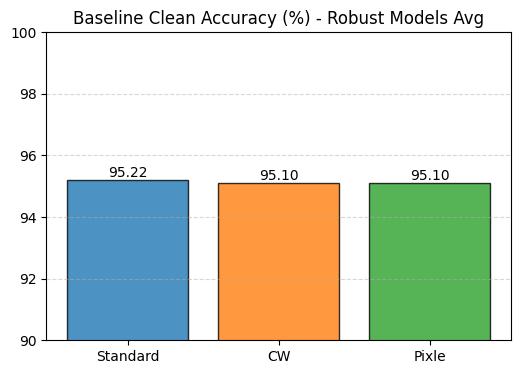

Baseline Clean Accuracy (%):
Standard: 95.22%
CW: 95.10%
Pixle: 95.10%


In [92]:
# 1. Clean Accuracy
plt.figure(figsize=(6, 4))
bars = plt.bar(attacks, metrics_data["Baseline Clean Accuracy (%)"], color=colors, alpha=0.8, edgecolor='black')
plt.title("Baseline Clean Accuracy (%) - Robust Models Avg")
plt.ylim(90, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.show()

print("Baseline Clean Accuracy (%):")
for a, v in zip(attacks, metrics_data["Baseline Clean Accuracy (%)"]):
    print(f"{a}: {v:.2f}%")

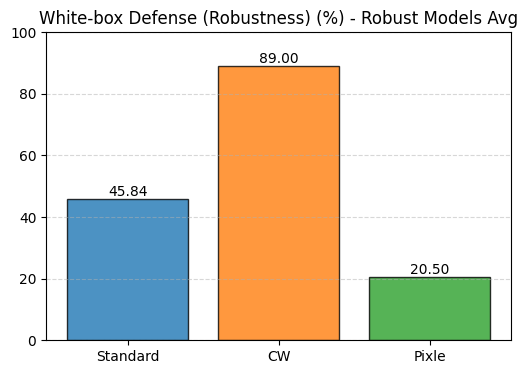

White-box Defense (Robustness) (%):
Standard: 45.84%
CW: 89.00%
Pixle: 20.50%


In [93]:
# 2. White-box Defense
plt.figure(figsize=(6, 4))
bars = plt.bar(attacks, metrics_data["White-box Defense (Robustness) (%)"], color=colors, alpha=0.8, edgecolor='black')
plt.title("White-box Defense (Robustness) (%) - Robust Models Avg")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.show()

print("White-box Defense (Robustness) (%):")
for a, v in zip(attacks, metrics_data["White-box Defense (Robustness) (%)"]):
    print(f"{a}: {v:.2f}%")

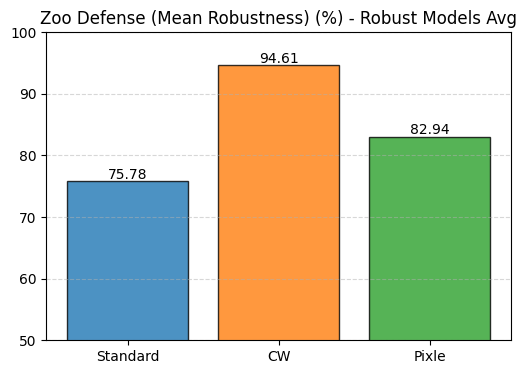

Zoo Defense (Mean Robustness) (%):
Standard: 75.78%
CW: 94.61%
Pixle: 82.94%


In [94]:
# 3. Zoo Defense
plt.figure(figsize=(6, 4))
bars = plt.bar(attacks, metrics_data["Zoo Defense (Mean Robustness) (%)"], color=colors, alpha=0.8, edgecolor='black')
plt.title("Zoo Defense (Mean Robustness) (%) - Robust Models Avg")
plt.ylim(50, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.show()

print("Zoo Defense (Mean Robustness) (%):")
for a, v in zip(attacks, metrics_data["Zoo Defense (Mean Robustness) (%)"]):
    print(f"{a}: {v:.2f}%")

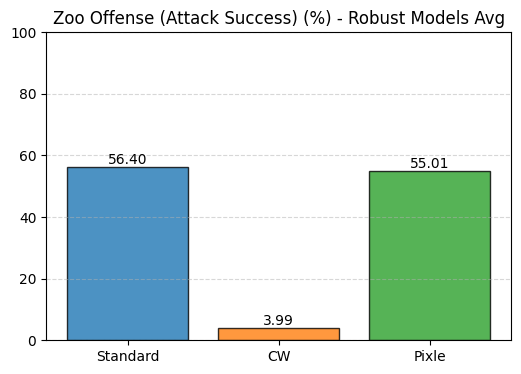

Zoo Offense (Attack Success) (%):
Standard: 56.40%
CW: 3.99%
Pixle: 55.01%


In [95]:
# 4. Zoo Offense
plt.figure(figsize=(6, 4))
bars = plt.bar(attacks, metrics_data["Zoo Offense (Attack Success) (%)"], color=colors, alpha=0.8, edgecolor='black')
plt.title("Zoo Offense (Attack Success) (%) - Robust Models Avg")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.show()

print("Zoo Offense (Attack Success) (%):")
for a, v in zip(attacks, metrics_data["Zoo Offense (Attack Success) (%)"]):
    print(f"{a}: {v:.2f}%")

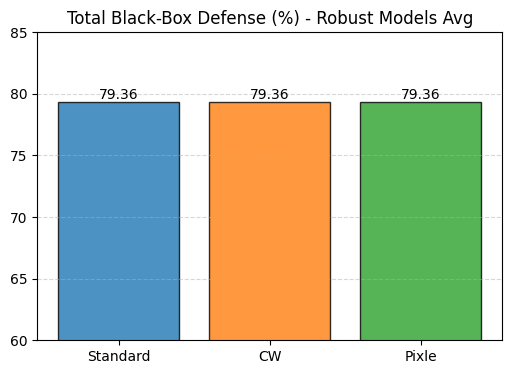

Total Black-Box Defense (%):
Standard: 79.36%
CW: 79.36%
Pixle: 79.36%


In [96]:
# 5. Total Black-Box Defense
plt.figure(figsize=(6, 4))
bars = plt.bar(attacks, metrics_data["Total Black-Box Defense (%)"], color=colors, alpha=0.8, edgecolor='black')
plt.title("Total Black-Box Defense (%) - Robust Models Avg")
plt.ylim(60, 85)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.show()

print("Total Black-Box Defense (%):")
for a, v in zip(attacks, metrics_data["Total Black-Box Defense (%)"]):
    print(f"{a}: {v:.2f}%")

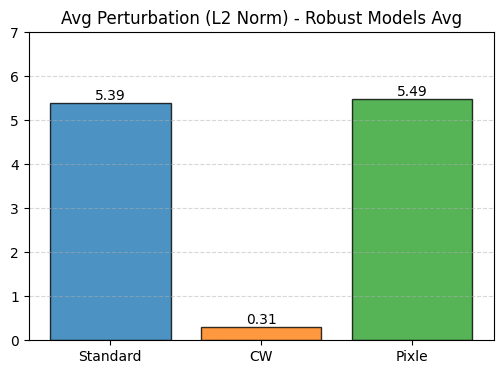

Avg Perturbation (L2 Norm):
Standard: 5.3896
CW: 0.3090
Pixle: 5.4877


In [97]:
# 6. Avg Perturbation
plt.figure(figsize=(6, 4))
bars = plt.bar(attacks, metrics_data["Avg Perturbation (L2 Norm)"], color=colors, alpha=0.8, edgecolor='black')
plt.title("Avg Perturbation (L2 Norm) - Robust Models Avg")
plt.ylim(0, 7)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.show()

print("Avg Perturbation (L2 Norm):")
for a, v in zip(attacks, metrics_data["Avg Perturbation (L2 Norm)"]):
    print(f"{a}: {v:.4f}")

In [99]:
import torch

# Load the file that caused the error
path = f"{adv_dir}/500_adv_lenet.pth"
print(f"Inspecting file: {path}")

try:
    test_data = torch.load(path)

    # 1. Print available keys to fix the KeyError
    if isinstance(test_data, dict):
        print(f"Keys found in file: {list(test_data.keys())}")
    else:
        print(f"File structure is not a dict, it is: {type(test_data)}")

    # 2. Once we know the keys, we can inspect ranges (assuming standard names if 'clean' is missing)
    # Common alternatives might be 'images', 'data', 'clean_img'
    # For now, just printing the keys will solve the mystery.

except Exception as e:
    print(f"Could not load file: {e}")

Inspecting file: /content/drive/My Drive/adversarial_mnist/large_adversarial_examples/500_adv_lenet.pth
Keys found in file: ['adv', 'lbl', 'avg_l2', 'score_clean', 'score_robust']
